# Setup
## Imports

In [1]:
from itertools import chain
import html
import ujson as json
import multiprocessing as mp
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

%matplotlib inline
sns.set(font='monospace')
df = pd.read_pickle('../../data/merged/data_to_use.pkl')

In [2]:
print(df.columns)

Index(['class', 'phone', 'dd_id', 'price', 'duration_in_mins', 'flag', 'age',
       'area', 'area_type', 'ethnicity', 'price_per_min', 'Disease', 'Year',
       'Cases', 'Rate', 'MSA', 'property', 'rape', 'violent', 'male_wage_mean',
       'male_wage_p05', 'male_wage_p10', 'male_wage_p25', 'male_wage_p50',
       'male_wage_p75', 'male_wage_p90', 'male_wage_p95', 'male_N',
       'male_epop', 'qcew_code', 'msa', 'population', 'unemployment',
       'lt_highschool', 'highschool', 'some_college', 'college_plus',
       'frac_white', 'avg_commute', 'female_wage_mean', 'wage_var.wage',
       'female_wage_p05', 'female_wage_p10', 'female_wage_p25',
       'female_wage_p50', 'female_wage_p75', 'female_wage_p90',
       'female_wage_p95', 'female_N', 'wage_sum.wght', 'female_epop',
       'swnauthemp', 'swnftemp', 'ad_p10_msa', 'ad_p90_msa', 'ad_mean_msa',
       'ad_median_msa', 'ad_count_msa', 'ad_p50_msa'],
      dtype='object')


## Induced features, relabeling, etc.
We could (and probably should) do this in the other notebook. But this is a fine  place for now

In [3]:
# df['class'] = df['class'].isin(['positive'])
df['class'] = df['class'].apply(lambda x: 1 if x == 'positive' else 0)
df['lt_23'] = df.age.apply(lambda x: True if x < 23 else False)

## Messing around
cross-tabs, etc. Can junk this section

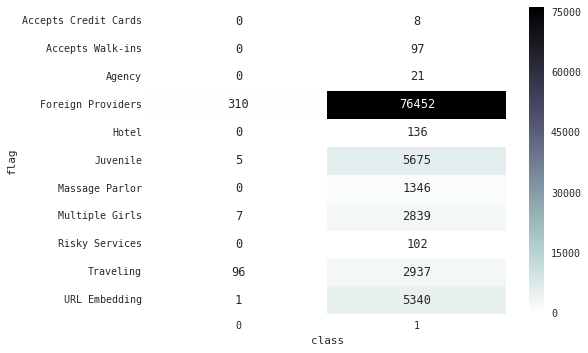

In [4]:
ct = pd.crosstab(df['class'], df.flag)
sns.heatmap(ct.T, annot=True, fmt='d', cmap='bone_r')

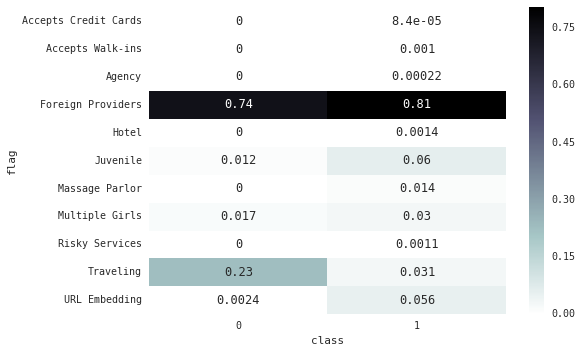

In [5]:
sns.heatmap(ct.T/ct.sum(axis=1), annot=True, cmap='bone_r')

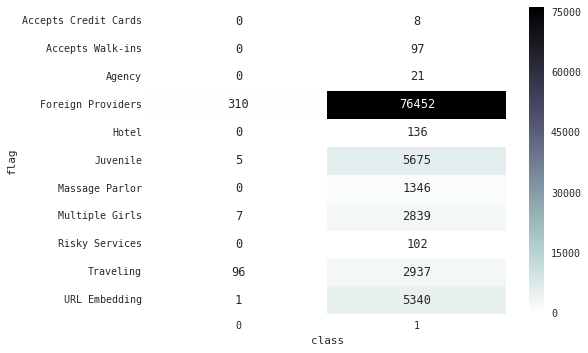

In [6]:
ct = pd.crosstab(df['class'], df.flag)
sns.heatmap(ct.T, annot=True, fmt='d', cmap='bone_r')

## Generate Splits
We can share these splits (or whatever the final splits end up being) across classifiers

In [7]:
splitter = ShuffleSplit(df.shape[0], 10)
splits = [x for x in splitter]

# Classifiers
## Linreg

We're using **dumb** folds. These should be smartened up.

### Slice DF

In [8]:
df_X = df.ix[:, ['age',
                 'lt_23',
                 'price',
                 'duration_in_mins',
                 'price_per_min',
                 'flag', 'ethnicity']].copy()

df_X.age = df_X.age.fillna(5000000)
df_X.price = df_X.price.fillna(5000000)
df_X.duration_in_mins = df_X.duration_in_mins.fillna(5000000)
df_X.price_per_min = df_X.price_per_min.fillna(5000000)
df_X = pd.get_dummies(df_X)

### Run model

In [33]:
def train_tester(df_X_train, y_train, df_X_test, y_test):
    lr = LinearRegression()
    lr.fit(df_X_train, y_train)
    y_pred = lr.predict(df_X_test)
    fpr, tpr, thresholds = roc_curve(y_test.values, y_pred)
    return {'model':lr,
            'y_pred': y_pred,
            'y_test': y_test.values,
            'lr_score': lr.score(df_X_test, y_test),
            'roc': (fpr, tpr, thresholds),
            'auc': auc(fpr, tpr)
            }


p = mp.Pool(10)
lrs = p.starmap(train_tester,
                [(df_X.iloc[train_ix, :],
                  df['class'].iloc[train_ix],
                  df_X.iloc[test_ix, :],
                  df['class'].iloc[test_ix])
                 for train_ix, test_ix in splits])
p.close()
p.join()

In [34]:
pd.Series([lr['lr_score'] for lr in lrs]).describe()

count    10.000000
mean      0.053941
std       0.004306
min       0.046316
25%       0.052963
50%       0.053825
75%       0.056498
max       0.060469
dtype: float64

In [36]:
pd.Series([lr['auc'] for lr in lrs]).describe()

count    10.000000
mean      0.853317
std       0.007440
min       0.836896
25%       0.850181
50%       0.853791
75%       0.859532
max       0.861256
dtype: float64

With these splits and features, our linear model _juuuuust_ a little better than the mean. Thanks, skewed data :(

In [29]:
roc_df = pd.DataFrame({'fpr': pd.DataFrame.from_records([lr['roc'][0] for lr in lrs]).apply(np.mean),
                       'tpr': pd.DataFrame.from_records([lr['roc'][1] for lr in lrs]).apply(np.mean)})
roc_df.set_index('fpr', inplace=True)

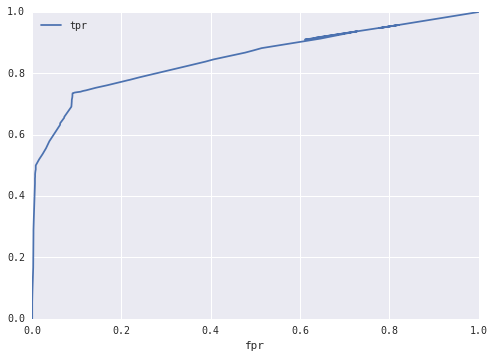

In [32]:
roc_df.plot()

In [ ]:
df_slice = df.ix[:, ['label','age', 'lt_23', 'price', 'duration_in_mins', 'price_per_min']].copy()

for x in ['age', 'price', 'duration_in_mins', 'price_per_min']:
    df_slice[x] = df_slice[x].fillna(5000000)

df_X = df_slice.ix[:, ['age', 'price', 'lt_23', 'duration_in_mins', 'price_per_min']]
y = df_slice.label

lr = LinearRegression()
lr.fit(df_X, y)
print(lr.coef_.shape)
print(lr.intercept_)
lr.score(df_X, y)

## Simple, unfolded, dumb random forest

In [ ]:
etc = ExtraTreesClassifier()

